In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/sentiment-analysis-for-mental-health/Combined Data.csv


In [2]:
import warnings
import os
warnings.filterwarnings('ignore')
os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [4]:
import pandas as pd
import numpy as np
import re
import torch
from transformers import AutoTokenizer
from transformers import BertModel
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader,Dataset
import torch.nn as nn

In [5]:
df = pd.read_csv('/kaggle/input/sentiment-analysis-for-mental-health/Combined Data.csv')
df.head()

,Unnamed: 0,statement,status
0,0,oh my gosh,Anxiety
1,1,"trouble sleeping, confused mind, restless hear...",Anxiety
2,2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety
3,3,I've shifted my focus to something else but I'...,Anxiety
4,4,"I'm restless and restless, it's been a month n...",Anxiety


In [6]:
df.shape

(53043, 3)

In [7]:
df['status'].value_counts()

status
Normal                  16351
Depression              15404
Suicidal                10653
Anxiety                  3888
Bipolar                  2877
Stress                   2669
Personality disorder     1201
Name: count, dtype: int64

In [8]:
df.isnull().sum()

Unnamed: 0      0
statement     362
status          0
dtype: int64

In [9]:
df = df.dropna(axis=0)

In [10]:
df.drop(columns = ['Unnamed: 0'],inplace=True)

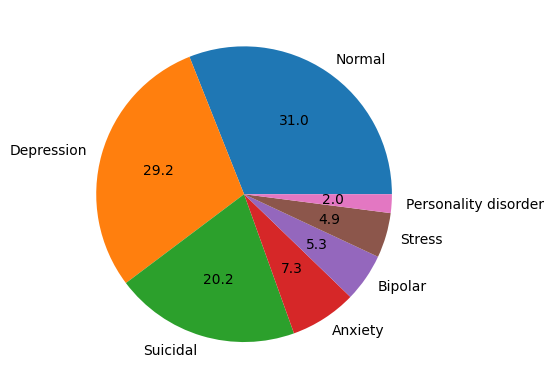

In [11]:
plt.pie(df['status'].value_counts(),labels=df['status'].value_counts().index,autopct='%.1f')
plt.show()

In [12]:
le = LabelEncoder()
df['status'] = le.fit_transform(df['status'])

In [13]:
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(df['status']),
    y=df['status']
)
class_weights = torch.tensor(class_weights, dtype=torch.float)

In [14]:
def preprocess(text):
  text = re.sub(r"http\S+|www\S+", "", text)  
  text = re.sub(r"@\w+", "", text)            
  text = re.sub(r"#", "", text)              
  text = re.sub(r"\s+", " ", text).strip()    
  return text

In [15]:
df['clean_text']=df['statement'].apply(preprocess)

In [16]:
X_train,X_test,y_train,y_test = train_test_split(df['clean_text'],df['status'],test_size=0.15,stratify=df["status"],random_state=42)

In [17]:
class MentalHealth_dataset(Dataset):
  def __init__(self,labels,tokens):
    self.labels = labels
    self.tokens = tokens
  
  def __len__(self):
    return len(self.labels)

  def __getitem__(self,idx):
    return {
        'input_ids' : self.tokens['input_ids'][idx],
        'attention_mask' : self.tokens['attention_mask'][idx],
        'label' : torch.tensor(self.labels[idx],dtype=torch.long)
    }

In [18]:
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

In [19]:
training_tokens = tokenizer(list(X_train),truncation=True, padding='max_length', max_length=256, return_tensors='pt')
train_dataset = MentalHealth_dataset(y_train.tolist(),training_tokens)

test_tokens = tokenizer(list(X_test),truncation=True, padding='max_length', max_length=256, return_tensors='pt')
test_dataset = MentalHealth_dataset(y_test.tolist(),test_tokens)

In [21]:
train_loader = DataLoader(train_dataset,batch_size=16,shuffle=True,pin_memory=True,num_workers=2,persistent_workers=True,prefetch_factor=2)
test_loader = DataLoader(test_dataset,batch_size=16,pin_memory=True,num_workers=2,persistent_workers=True)

In [22]:
class BertLSTMClassifier(nn.Module):
  def __init__(self,bert_model_name='bert-base-uncased',num_classes=7,dropout=0.3,hidden_dims=128,):
    super().__init__()

    self.bert = BertModel.from_pretrained(bert_model_name)

    for param in self.bert.parameters():
      param.requires_grad = False

    self.lstm = nn.LSTM(
        input_size = self.bert.config.hidden_size,
        hidden_size=hidden_dims,
        bidirectional=True,
        batch_first=True
    )

    self.dropout = nn.Dropout(dropout)

    self.linear = nn.Linear(hidden_dims*2,num_classes)

  
  def forward(self,input_ids,attention_mask):
    with torch.no_grad():
      outputs = self.bert(input_ids=input_ids,attention_mask=attention_mask)
      embedding = outputs.last_hidden_state

    intermediate_hidden_outs,(final_hidden_state,cell_state) = self.lstm(embedding)
    hidden = torch.cat((final_hidden_state[-2],final_hidden_state[-1]),dim=1)

    out = self.dropout(hidden)

    logits = self.linear(out)
    return logits

In [23]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
class_weights = class_weights.to(device)
criterior = nn.CrossEntropyLoss(weight=class_weights)
epochs = 10
learning_rate = 0.01
model = BertLSTMClassifier()
model.to(device) 
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)

In [24]:
for epoch in range(epochs):
  total_loss = 0
  for batch in train_loader:
    input_ids = batch['input_ids'].to(device)
    attention_mask = batch['attention_mask'].to(device)
    labels = batch['label'].to(device) 

    optimizer.zero_grad()

    logits = model(input_ids,attention_mask)

    loss = criterior(logits,labels)

    loss.backward()
    
    optimizer.step()

    total_loss += loss.item()

  avg_loss = total_loss / len(train_loader)
  print(f'Epoch : {epoch}, loss : {avg_loss}')

Epoch : 0, loss : 1.3228174997636701
Epoch : 1, loss : 1.0609747266590532
Epoch : 2, loss : 1.0124989725614753
Epoch : 3, loss : 0.9916490527264515
Epoch : 4, loss : 0.9412989738786932
Epoch : 5, loss : 0.9097132747643503
Epoch : 6, loss : 0.8809558448939717
Epoch : 7, loss : 0.8348527162010732
Epoch : 8, loss : 0.8210507964541675
Epoch : 9, loss : 0.8471527536768665


In [33]:
model.eval()
correct = 0
val_loss = 0
total = 0
with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device) 

        logits = model(input_ids,attention_mask)
        loss = criterior(logits,labels)
        val_loss += loss.item()
        preds = torch.argmax(logits, dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

avg_val_loss = val_loss / len(test_loader)
accuracy = correct / total
print(f'avg_val_loss : {avg_val_loss}, accuracy : {accuracy}')

avg_val_loss : 0.7021231831990273, accuracy : 0.7018853599898772


In [34]:
from sklearn.metrics import classification_report

all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        logits = model(input_ids, attention_mask)
        preds = torch.argmax(logits, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

print(classification_report(all_labels, all_preds, target_names=[
    "Normal", "Depression", "Suicidal", "Anxiety", "Bipolar", "Stress", "Personality Disorder"
]))

                      precision    recall  f1-score   support

              Normal       0.66      0.80      0.73       576
          Depression       0.62      0.78      0.69       417
            Suicidal       0.82      0.43      0.57      2311
             Anxiety       0.95      0.83      0.89      2452
             Bipolar       0.33      0.84      0.47       161
              Stress       0.54      0.65      0.59       388
Personality Disorder       0.55      0.84      0.66      1598

            accuracy                           0.70      7903
           macro avg       0.64      0.74      0.66      7903
        weighted avg       0.76      0.70      0.70      7903

